# **Importing Necassary Libraries**

In [ ]:
import pandas as pd
import numpy as np
import cv2
import os
import re

from PIL import Image

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

from matplotlib import pyplot as plt



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/LetsPrompt Fiverr Projects/Order XX - Faster RCNN (Lungs disease detection)

/content/drive/MyDrive/LetsPrompt Fiverr Projects/Order XX - Faster RCNN (Lungs disease detection)


In [ ]:
%%time
xray_train = pd.read_csv('super-annotation.csv')

xray_train.head()

CPU times: user 18.4 ms, sys: 1.99 ms, total: 20.4 ms
Wall time: 656 ms


,img_name,label,x,y,height,width
0,00001688_000.png,1,333.748148,138.158730,75.310053,61.223280
1,00004547_003.png,1,449.693122,345.125926,29.257143,26.548148
2,00023078_000.png,1,370.590476,343.500529,24.380952,26.006349
3,00023068_003.png,1,175.542857,373.841270,16.795767,17.879365
4,00013911_000.png,1,59.056085,241.642328,50.929101,42.802116


In [ ]:
image_ids = xray_train['img_name'].unique()

valid_ids = image_ids[-665:]
train_ids = image_ids[:-665]

In [ ]:
valid_df = xray_train[xray_train['img_name'].isin(valid_ids)]
train_df = xray_train[xray_train['img_name'].isin(train_ids)]

In [ ]:
valid_df.shape, train_df.shape

((665, 6), (4087, 6))

# **Data Retriever**

In [ ]:
class xrayDataset(Dataset):

    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()

        dataframe = dataframe.dropna()

        self.image_ids = dataframe['img_name'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms

    def __getitem__(self, index: int):

        image_id = self.image_ids[index]

        records = self.df[self.df['img_name'] == image_id]

        image = cv2.imread(f'{self.image_dir}/{image_id}').astype(np.float32)

        image /= 255.0

        boxes = records[['x', 'y', 'width', 'height']].to_numpy()
        area = (boxes[:, 3]) * (boxes[:, 2])
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        area = torch.as_tensor(area, dtype=torch.float32)

        labels = torch.ones((records.shape[0],), dtype=torch.int64)

        iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)

        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['img_name'] = torch.tensor([index])
        target['area'] = area
        target['iscrowd'] = iscrowd

        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']

            target['boxes'] =  torch.tensor(sample['bboxes']).float()

        return image, target, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

In [ ]:
def get_train_transform():
    return A.Compose(
        [
            A.OneOf([
                A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2,
                                     val_shift_limit=0.2, p=0.9),
                A.RandomBrightnessContrast(brightness_limit=0.2,
                                           contrast_limit=0.2, p=0.9),
            ], p=0.9),
            A.ToGray(p=0.01),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.Resize(height=512, width=512, p=1),
            ToTensorV2(p=1.0),
        ],
        p=1.0,
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0,
            min_visibility=0,
            label_fields=['labels']
        )
    )


def get_valid_transform():
    return A.Compose(
        [
            A.Resize(height=512, width=512, p=1.0),
            ToTensorV2(p=1.0),
        ],
        p=1.0,
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0,
            min_visibility=0,
            label_fields=['labels']
        )
    )

# **Train Loader**

In [ ]:
import os

def collate_fn(batch):
    return tuple(zip(*batch))

current_path = os.getcwd()
DIR_INPUT = current_path
DIR_TRAIN = f'{DIR_INPUT}/train'
DIR_TEST = f'{DIR_INPUT}/test'

train_dataset = xrayDataset(train_df, DIR_TRAIN, get_train_transform())
valid_dataset = xrayDataset(valid_df, DIR_TRAIN, get_valid_transform())

indices = torch.randperm(len(train_dataset)).tolist()

train_data_loader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# **Sample**

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
images, targets, image_ids = next(iter(train_data_loader))

images = [image.to(device) for image in images]
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [ ]:
boxes = targets[10]['boxes'].cpu().numpy().astype(np.int32)
print(boxes.shape)
sample = images[10].permute(1, 2, 0).cpu().numpy()

(1, 4)


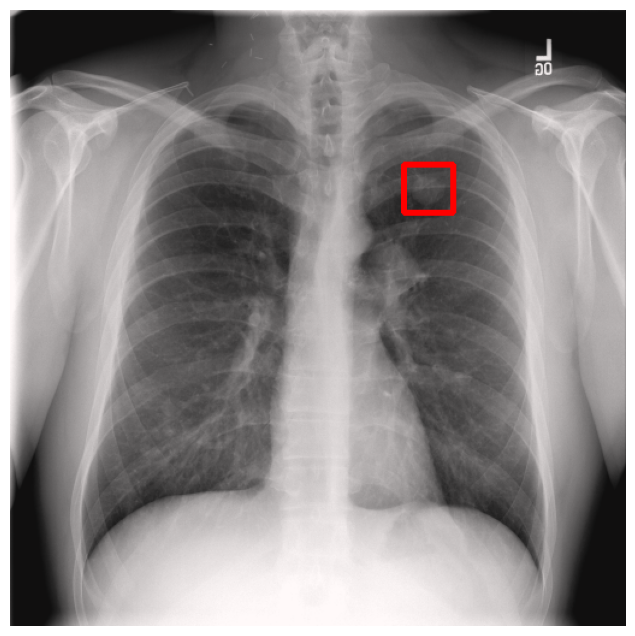

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 3)

ax.set_axis_off()

ax.imshow(sample)

# **Faster RCNN**

In [ ]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 100MB/s] 


In [ ]:
num_classes = 2

in_features = model.roi_heads.box_predictor.cls_score.in_features

model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# **Pre Calculation**

In [ ]:
class Faster_RCNN_Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0


In [ ]:
def calculate_iou(gt, pr, form='pascal_voc') -> float:
    if form == 'coco':
        gt = gt.copy()
        pr = pr.copy()

        gt[2] = gt[0] + gt[2]
        gt[3] = gt[1] + gt[3]
        pr[2] = pr[0] + pr[2]
        pr[3] = pr[1] + pr[3]

    dx = min(gt[2], pr[2]) - max(gt[0], pr[0]) + 1

    if dx < 0:
        return 0.0
    dy = min(gt[3], pr[3]) - max(gt[1], pr[1]) + 1

    if dy < 0:
        return 0.0

    overlap_area = dx * dy

    union_area = (
            (gt[2] - gt[0] + 1) * (gt[3] - gt[1] + 1) +
            (pr[2] - pr[0] + 1) * (pr[3] - pr[1] + 1) -
            overlap_area
    )

    return overlap_area / union_area

In [ ]:
def find_best_match(gts, pred, pred_idx, threshold = 0.5, form = 'pascal_voc', ious=None) -> int:
    best_match_iou = -np.inf
    best_match_idx = -1
    for gt_idx in range(len(gts)):

        if gts[gt_idx][0] < 0:
            continue

        iou = -1 if ious is None else ious[gt_idx][pred_idx]

        if iou < 0:
            iou = calculate_iou(gts[gt_idx], pred, form=form)

            if ious is not None:
                ious[gt_idx][pred_idx] = iou

        if iou < threshold:
            continue

        if iou > best_match_iou:
            best_match_iou = iou
            best_match_idx = gt_idx

    return best_match_idx

In [ ]:
def calculate_precision(gts, preds, threshold = 0.5, form = 'coco', ious=None) -> float:
    n = len(preds)
    tp = 0
    fp = 0

    for pred_idx in range(n):

        best_match_gt_idx = find_best_match(gts, preds[pred_idx], pred_idx,
                                            threshold=threshold, form=form, ious=ious)

        if best_match_gt_idx >= 0:
            tp += 1
            gts[best_match_gt_idx] = -1
        else:
            fp += 1

    fn = (gts.sum(axis=1) > 0).sum()

    return tp / (tp + fp + fn)

In [ ]:
def calculate_image_precision(gts, preds, thresholds = (0.5, ), form = 'coco') -> float:
    n_threshold = len(thresholds)
    image_precision = 0.0

    ious = np.ones((len(gts), len(preds))) * -1

    for threshold in thresholds:
        precision_at_threshold = calculate_precision(gts.copy(), preds, threshold=threshold,
                                                     form=form, ious=ious)
        image_precision += precision_at_threshold / n_threshold

    return image_precision

# **Model Train and Evaluation**

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/Faster_RCNN/fasterrcnn_resnet50_fpn.pth',map_location=torch.device('cpu')))
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)
num_epochs = 5


In [ ]:
train_hist = Faster_RCNN_Averager()
t = 1
valid_pred_min = 0.65
for epoch in range(num_epochs):
    train_hist.reset()

    model.train()
    for images, targets, image_ids in train_data_loader:

        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        train_loss = losses.item()

        train_hist.send(train_loss)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if t % 50 == 0:
            print(f"Iteration #{t} loss: {train_loss}")

        t += 1


    model.eval()
    validation_image_precisions = []
    iou_thresholds = [x for x in np.arange(0.5, 0.76, 0.05)]
    for images, targets, image_ids in valid_data_loader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        with torch.no_grad():
            outputs = model(images)




        for i, image in enumerate(images):
            boxes = outputs[i]['boxes'].data.cpu().numpy()
            scores = outputs[i]['scores'].data.cpu().numpy()
            gt_boxes = targets[i]['boxes'].cpu().numpy()
            preds_sorted_idx = np.argsort(scores)[::-1]
            preds_sorted = boxes[preds_sorted_idx]
            image_precision = calculate_image_precision(preds_sorted,
                                                        gt_boxes,
                                                        thresholds=iou_thresholds,
                                                        form='coco')
            validation_image_precisions.append(image_precision)

    valid_prec = np.mean(validation_image_precisions)
    print("Validation IOU: {0:.4f}".format(valid_prec))

    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch,
        train_loss
    ))

    if valid_prec >= valid_pred_min:
        print('Validation precision increased({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_pred_min,
            valid_prec))
        torch.save(model.state_dict(), 'fasterrcnn_resnet50_fpn_best.pth')
        valid_pred_min = valid_prec



Iteration #50 loss: 0.22199968993663788
Iteration #100 loss: 0.24399742484092712
Iteration #150 loss: 0.23287546634674072
Iteration #200 loss: 0.2125726044178009
Validation IOU: 0.0838
Epoch: 0 	Training Loss: 0.185221
Iteration #250 loss: 0.19762156903743744
Iteration #300 loss: 0.1978943943977356
Iteration #350 loss: 0.12887778878211975
Iteration #400 loss: 0.2743496000766754
Validation IOU: 0.1032
Epoch: 1 	Training Loss: 0.184817
Iteration #450 loss: 0.21513834595680237
Iteration #500 loss: 0.1408098191022873
Iteration #550 loss: 0.12106204032897949
Iteration #600 loss: 0.18867428600788116
Validation IOU: 0.1165
Epoch: 2 	Training Loss: 0.165135
Iteration #650 loss: 0.11720660328865051
Iteration #700 loss: 0.11878522485494614
Iteration #750 loss: 0.18166221678256989
Iteration #800 loss: 0.1543743759393692
Iteration #850 loss: 0.15269796550273895
Validation IOU: 0.1182
Epoch: 3 	Training Loss: 0.147965
Iteration #900 loss: 0.12924964725971222
Iteration #950 loss: 0.2033044695854187


# **Model Evaluation**

In [ ]:
model.eval()
images, targets, image_ids = next(iter(valid_data_loader))
images = list(image.to(device) for image in images)
outputs = model(images)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [ ]:
detection_threshold = 0.5
sample = images[6].permute(1,2,0).cpu().numpy()
boxes = outputs[6]['boxes'].data.cpu().numpy()
scores = outputs[6]['scores'].data.cpu().numpy()
boxes = boxes[scores >= detection_threshold].astype(np.int32)

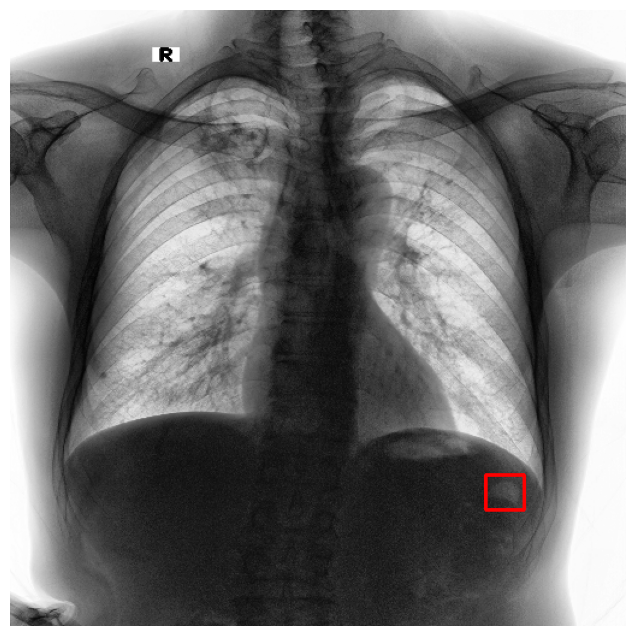

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 2)

ax.set_axis_off()
ax.imshow(sample)

# **Evaluation Matrics**

In [ ]:
import torch
import numpy as np
from sklearn.metrics import precision_recall_fscore_support, average_precision_score
from collections import defaultdict

def calculate_precision_recall(targets, outputs, iou_threshold=0.5):
    true_positives = 0
    false_positives = 0
    total_ground_truths = 0

    for output, target in zip(outputs, targets):
        ious = calculate_iou(target, output)
        if len(ious) > 0:
            max_iou = np.max(ious)
            if max_iou >= iou_threshold:
                true_positives += 1
            else:
                false_positives += 1
        else:
            false_positives += 1

        total_ground_truths += len(target)

    precision = true_positives / (true_positives + false_positives)
    recall = true_positives / total_ground_truths

    return precision, recall


def calculate_iou(gt, pr):
    x1 = np.maximum(gt[:, 0][:, np.newaxis], pr[:, 0])
    y1 = np.maximum(gt[:, 1][:, np.newaxis], pr[:, 1])
    x2 = np.minimum(gt[:, 2][:, np.newaxis], pr[:, 2])
    y2 = np.minimum(gt[:, 3][:, np.newaxis], pr[:, 3])

    intersection = np.maximum(x2 - x1 + 1, 0) * np.maximum(y2 - y1 + 1, 0)
    gt_area = (gt[:, 2] - gt[:, 0] + 1) * (gt[:, 3] - gt[:, 1] + 1)
    pr_area = (pr[:, 2] - pr[:, 0] + 1) * (pr[:, 3] - pr[:, 1] + 1)

    union = gt_area[:, np.newaxis] + pr_area - intersection

    iou = intersection / union

    return iou

def calculate_f1_score(precision, recall):
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    return f1_score

In [ ]:
gt_boxes = [target['boxes'].cpu().numpy() for target in targets]
pred_boxes = [output['boxes'].data.cpu().numpy() for output in outputs]

gt_boxes_flat = np.concatenate(gt_boxes)

pred_boxes_flat = np.concatenate([np.concatenate(pred) for pred in pred_boxes])

precision, recall = calculate_precision_recall(gt_boxes, pred_boxes)
print("Precision:", precision)
print("Recall:", recall)

f1_score = calculate_f1_score(precision, recall)
print("F1-Score:", f1_score)

Precision: 0.875
Recall: 0.875
F1-Score: 0.875


# **TESTING**

As we have already trained our model we'll directly give it's weight

In [ ]:
WEIGHTS_FILE = '/content/drive/MyDrive/Faster_RCNN/fasterrcnn_resnet50_fpn.pth'

Giving a dummy file and the bbox coordinate will be written into it

In [ ]:
test_df = pd.read_csv('/content/sample_submission.csv')
test_df.shape

(10, 2)

In [ ]:
class xray_test(Dataset):

    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()

        self.image_ids = dataframe['img_name'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms

    def __getitem__(self, index: int):

        image_id = self.image_ids[index]
        records = self.df[self.df['img_name'] == image_id]

        image = cv2.imread(f'{self.image_dir}/{image_id}', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0

        if self.transforms:
            sample = {
                'image': image,
            }
            sample = self.transforms(**sample)
            image = sample['image']

        return image, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

In [ ]:
def get_test_transform():
    return A.Compose([
        ToTensorV2(p=1.0)
    ])


In [ ]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False, pretrained_backbone=False)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained_backbone' is deprecated since 0.13 and may be removed in the future, please use 'weights_backbone' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights_backbone' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to 

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_classes = 2 

in_features = model.roi_heads.box_predictor.cls_score.in_features

model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

model.load_state_dict(torch.load(WEIGHTS_FILE, map_location=torch.device('cpu')))
model.eval()

x = model.to(device)

In [ ]:
DIR_INPUT = '/content/drive/MyDrive/Faster_RCNN'
DIR_TRAIN = f'{DIR_INPUT}/train'
DIR_TEST = f'{DIR_INPUT}/test'

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

test_dataset = xray_test(test_df, DIR_TEST, get_test_transform())

test_data_loader = DataLoader(
    test_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=2,
    drop_last=False,
    collate_fn=collate_fn
)

In [ ]:
def format_prediction_string(boxes, scores):
    pred_strings = []
    for j in zip(scores, boxes):
        pred_strings.append("{0:.4f} {1} {2} {3} {4}".format(j[0], j[1][0], j[1][1], j[1][2], j[1][3]))

    return " ".join(pred_strings)

In [ ]:
detection_threshold = 0.5
results = []

for images, image_ids in test_data_loader:

    images = list(image.to(device) for image in images)
    outputs = model(images)

    for i, image in enumerate(images):

        boxes = outputs[i]['boxes'].data.cpu().numpy()
        scores = outputs[i]['scores'].data.cpu().numpy()

        boxes = boxes[scores >= detection_threshold].astype(np.int32)
        scores = scores[scores >= detection_threshold]
        image_id = image_ids[i]

        boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
        boxes[:, 3] = boxes[:, 3] - boxes[:, 1]

        result = {
            'img_name': image_id,
            'PredictionString': format_prediction_string(boxes, scores)
        }


        results.append(result)


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [ ]:
results[0:6]

In [ ]:
test_df = pd.DataFrame(results, columns=['img_name', 'PredictionString'])
test_df.head()

In [ ]:
sample = images[1].permute(1,2,0).cpu().numpy()
boxes = outputs[1]['boxes'].data.cpu().numpy()
scores = outputs[1]['scores'].data.cpu().numpy()

boxes = boxes[scores >= detection_threshold].astype(np.int32)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 2)

ax.set_axis_off()
ax.imshow(sample)

In [ ]:
test_df.to_csv('submission.csv', index=False)

Extra To check the bounding Bpx on the image

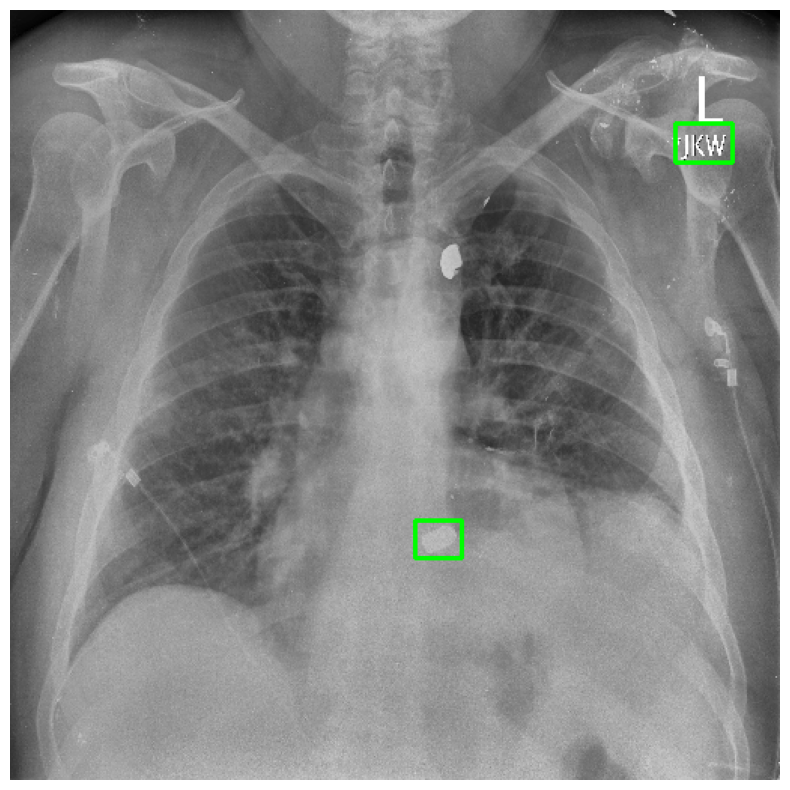

In [ ]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

def draw_boxes_on_image(image, prediction_string):
    predictions = prediction_string.split()
    for i in range(0, len(predictions), 5):
        x, y, width, height = map(int, predictions[i+1:i+5])
        cv2.rectangle(image, (x, y), (x + width, y + height), (0, 255, 0), 2)

    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

image_path = '/content/drive/MyDrive/Faster_RCNN/test/n0005-hc.png'

prediction_string = "0.7702 269 339 31 25 0.7407 442 75 38 26"

image = cv2.imread(image_path)

draw_boxes_on_image(image, prediction_string)